# **Title**

## Introduction
### Background Information
- Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report.
### Question of the Project
The question we are trying to answer in this project is 
**Can Player Age Predict the Total Number of Gameplay Sessions Contributed?**

### The Datasets: player.csv and sessions.csv
Dataset Identify and fully describe the dataset that was used to answer the question (Christy)

## Methods & Results

- describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which:
    - loads data (Griffin)
    - wrangles and cleans the data to the format necessary for the planned analysis (Ryan)
    - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis (Ryan)
    - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis (Ryan)
    - performs the data analysis (Griffin)
    - creates a visualization of the analysis (TBD)
- note: all figures should have a figure number and a legend

In [18]:
library(tidyverse)
library(tidymodels)
library(knitr)
library(repr)

In [19]:
players_data <- read_csv("Data/players.csv")
sessions_data <- read_csv("Data/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Data Wrangling and Cleaning

In [20]:
# Count sessions per player
session_counts <- sessions_data |>
  filter(!is.na(end_time)) |>
  group_by(hashedEmail) |>
  summarise(num_sessions = n())

# Join with player data and clean
analysis_data <- players_data |>
  left_join(session_counts, by = "hashedEmail") |>
  mutate(
    num_sessions = replace_na(num_sessions, 0),
    Age = as.numeric(Age)
  ) |>
  filter(!is.na(Age))

# Display summary
cat("Cleaned dataset contains", nrow(analysis_data), "players with complete age data\n")
cat("Players with at least one session:", sum(analysis_data$num_sessions > 0), "\n")

Cleaned dataset contains 194 players with complete age data
Players with at least one session: 123 


We performed the following data wrangling steps to prepare our dataset for analysis:

1. **Filtered incomplete sessions**: We removed sessions with missing end times from the sessions dataset
2. **Counted sessions per player**: We grouped the sessions data by each player's hashed email and counted how many sessions they had
3. **Joined datasets**: We combined the session counts with the player demographic data using the hashed email as the key
4. **Handled missing sessions**: Players who had no recorded sessions were assigned a count of 0
5. **Removed missing age values**: We filtered out players who did not have age data, leaving us with 194 players for analysis

This cleaned dataset contains all the information needed to explore whether player age can predict the number of gameplay sessions contributed.

### Summary Statistics for Exploratory Data Analysis

In [21]:
# Calculate summary statistics for Age
age_summary <- data.frame(
  Variable = "Age (years)",
  Mean = round(mean(analysis_data$Age, na.rm = TRUE), 2),
  SD = round(sd(analysis_data$Age, na.rm = TRUE), 2),
  Min = round(min(analysis_data$Age, na.rm = TRUE), 2),
  Max = round(max(analysis_data$Age, na.rm = TRUE), 2)
)

# Calculate summary statistics for Number of Sessions
sessions_summary <- data.frame(
  Variable = "Number of Sessions",
  Mean = round(mean(analysis_data$num_sessions), 2),
  SD = round(sd(analysis_data$num_sessions), 2),
  Min = round(min(analysis_data$num_sessions), 2),
  Max = round(max(analysis_data$num_sessions), 2)
)

# Combine into one table
summary_table <- rbind(age_summary, sessions_summary)
kable(summary_table, caption = "Table 1: Summary Statistics for Age and Session Count")

# Additional relevant statistics
cat("\n**Key Statistics:**\n")
cat("- Correlation between Age and Sessions:", 
    round(cor(analysis_data$Age, analysis_data$num_sessions), 3), "\n")
cat("- Percentage of players with 0 sessions:", 
    round(sum(analysis_data$num_sessions == 0) / nrow(analysis_data) * 100, 1), "%\n")
cat("- Percentage of players with 10+ sessions:", 
    round(sum(analysis_data$num_sessions >= 10) / nrow(analysis_data) * 100, 1), "%\n")



Table: Table 1: Summary Statistics for Age and Session Count

|Variable           |  Mean|    SD| Min| Max|
|:------------------|-----:|-----:|---:|---:|
|Age (years)        | 21.14|  7.39|   9|  58|
|Number of Sessions |  7.89| 33.64|   0| 310|


**Key Statistics:**
- Correlation between Age and Sessions: -0.055 
- Percentage of players with 0 sessions: 36.6 %
- Percentage of players with 10+ sessions: 8.8 %


The summary statistics reveal important patterns in our dataset. Players range from 9 to 58 years old, with an average age of about 21 years. The number of sessions varies widely, from 0 to over 300 sessions, though most players have relatively few sessions (mean = 7.89). 

The correlation between age and sessions is very weak (-0.055), suggesting that age alone may not be a strong predictor of player engagement. Additionally, we see that a significant portion of players (about 37%) have zero sessions, while only a small percentage are highly engaged players with 10 or more sessions. This initial exploration suggests we should be cautious about expecting a strong predictive relationship between age and session count.

### Exploratory Data Visualization

`geom_smooth()` using formula = 'y ~ x'


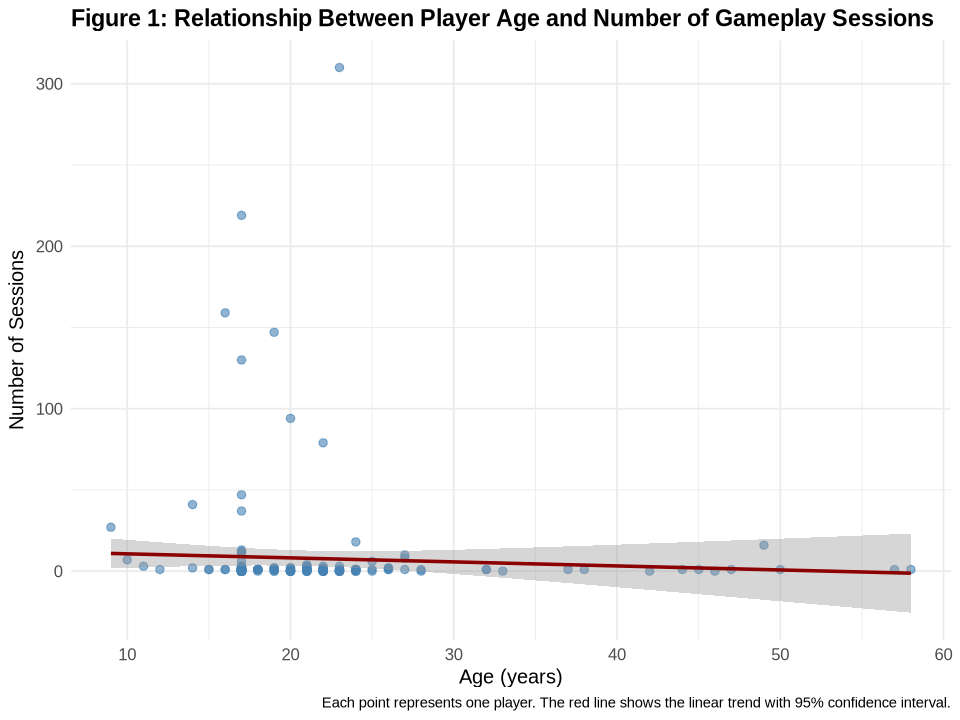

In [23]:
# Set figure size for better readability
options(repr.plot.width = 8, repr.plot.height = 6)

# Create scatter plot with regression line
ggplot(analysis_data, aes(x = Age, y = num_sessions)) +
  geom_point(alpha = 0.6, color = "steelblue", size = 2) +
  geom_smooth(method = "lm", se = TRUE, color = "darkred", linewidth = 1) +
  labs(
    title = "Figure 1: Relationship Between Player Age and Number of Gameplay Sessions",
    x = "Age (years)",
    y = "Number of Sessions",
    caption = "Each point represents one player. The red line shows the linear trend with 95% confidence interval."
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10)
  )

Figure 1 shows the relationship between player age and the number of gameplay sessions contributed to the research server. Most players cluster near the bottom of the plot with fewer than 25 sessions, regardless of age. The nearly horizontal regression line (with a slight negative slope) indicates a very weak relationship between age and session count. 

While there are some notable outliers, particularly younger players (ages 15-25) with over 100 sessions, these high-engagement players appear across various ages. The wide confidence interval around the regression line further suggests substantial variability and uncertainty in predicting sessions based solely on age. This visual evidence supports our earlier finding from the correlation analysis that age may not be a strong predictor of player contribution to the research dataset.

## Discussion
- summarize what you found (Zoelle)

- discuss whether this is what you expected to find (Zoelle)


- discuss what impact could such findings have
- discuss what future questions could this lead to

## References
- You may include references if necessary, as long as they all have a consistent citation style.